# Title

## Links

> [Link to Brookings](https://www.brookings.edu/multi-chapter-report/vital-statistics-on-congress/)

> [Link to BallotPedia](https://ballotpedia.org/Legislative_Branch)

> [Link to WikiPedia](https://en.wikipedia.org/wiki/List_of_United_States_Senate_elections)

> [Link to Wiki-Category (U.S. Senator)](https://commons.wikimedia.org/wiki/Category:Senators_of_the_United_States)

## Imports

In [1]:
import functions as dlf
import pandas as pd
import numpy as np
import requests
import regex
import pickle
from importlib import reload
from bs4 import BeautifulSoup
from genderize import Genderize

In [3]:
import numpy as np
# import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import tzlocal
import datetime as dt
import xgboost as xgb
import sklearn
import sklearn.metrics as metrics
from yellowbrick.classifier import ROCAUC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')
%matplotlib inline

## Loading data

In [5]:
df = pd.read_csv('Senate_generals_thru_2016')
df_eda = df.copy()
df_gend = pd.read_csv('df_gend.csv')
df_model_test = df.copy()
display(df.tail())

,%,Turnout,Incumb_Y,State,Cln_name,Year,Terms_in_office,Party_enc,First_name,Seats_up%,Seats_before%
5583,1.01,320467.0,0,Vermont,Peter Diamondstone,2016,0,T,Peter,0.000000,0.00
5584,59.01,3243317.0,1,Washington,Patty Murray,2016,4,D,Patty,0.227273,0.44
5585,40.99,3243317.0,0,Washington,Chris Vance,2016,0,R,Chris,0.444444,0.54
5586,50.20,2947345.0,1,Wisconsin,Ron Johnson,2016,1,R,Ron,0.444444,0.54
5587,46.80,2947345.0,0,Wisconsin,Russ Feingold,2016,0,D,Russ,0.227273,0.44


## EDA

In [6]:
## Fill NAs left from cleaning
df_eda.dropna(inplace=True)

## Fixing State regex missed cases
df_eda.at[1461, 'State'] = 'West_Virginia'
df_eda.at[1632, 'State'] = 'Nevada'

df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5583 entries, 0 to 5587
Data columns (total 11 columns):
%                  5583 non-null float64
Turnout            5583 non-null float64
Incumb_Y           5583 non-null int64
State              5583 non-null object
Cln_name           5583 non-null object
Year               5583 non-null int64
Terms_in_office    5583 non-null int64
Party_enc          5583 non-null object
First_name         5583 non-null object
Seats_up%          5583 non-null float64
Seats_before%      5583 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 683.4+ KB


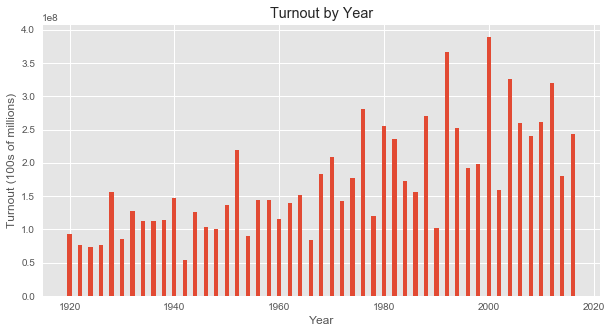

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

turnout_by_yr = df_eda.groupby('Year')['Turnout'].sum()
ax.bar(turnout_by_yr.index, turnout_by_yr)
ax.set(title='Turnout by Year', xlabel='Year', ylabel='Turnout (100s of millions)');

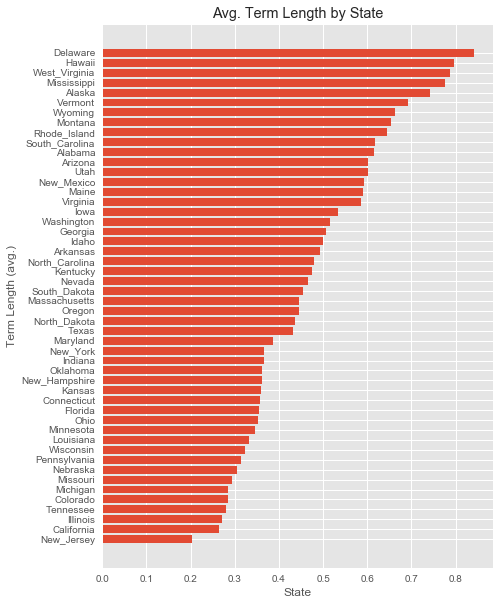

In [8]:
fig, ax = plt.subplots(figsize=(7,10))

terms_by_state = df_eda.groupby('State')['Terms_in_office'].mean()
ax.barh(terms_by_state.sort_values().index, terms_by_state.sort_values())
ax.set(title='Avg. Term Length by State', xlabel='State', ylabel='Term Length (avg.)');

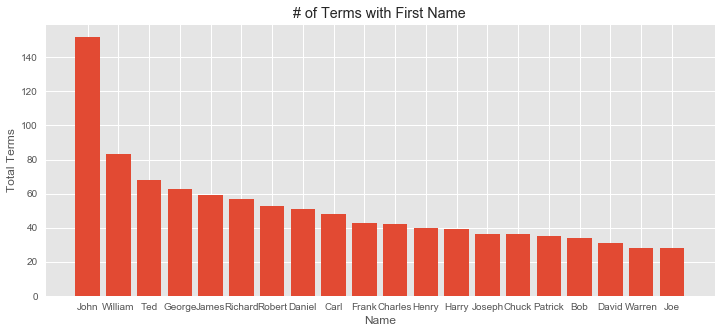

In [9]:
## First woman's name is barbara 16 occurences, 34th rank

fig, ax = plt.subplots(figsize=(12,5))

terms_by_firstname = df_eda.groupby('First_name')['Terms_in_office'].sum()
firstname_top20 = terms_by_firstname[terms_by_firstname > 0].sort_values(ascending=False).head(20)

ax.bar(firstname_top20.index, firstname_top20)
ax.set(title='# of Terms with First Name', xlabel='Name', ylabel='Total Terms');

In [10]:
party_enc_list = ['D', 'R', 'I', 'S', 'T']
party_series_dict = {}

for party in party_enc_list:
    if party == 'D':
        dems_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = dems_by_year
    elif party == 'R':
        repubs_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = repubs_by_year
    elif party == 'I':
        indeps_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = indeps_by_year
    elif party == 'S':
        socls_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = socls_by_year
    elif party == 'T':
        thirds_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = thirds_by_year

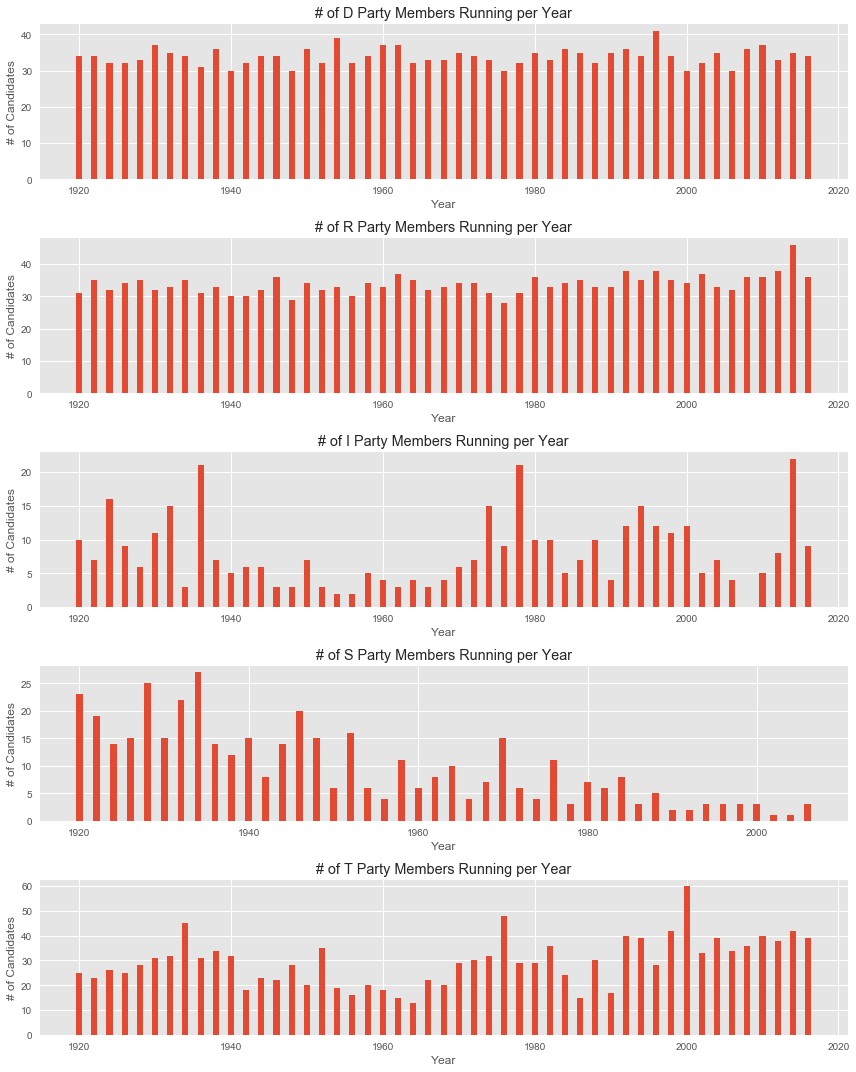

In [11]:
fig, ax = plt.subplots(figsize=(12,15), nrows=5)
axes = ax.flatten()

for i, party in enumerate(party_series_dict):
    series = party_series_dict[party]
    axes[i].bar(series.index, series)
    axes[i].set(title=f'# of {party} Party Members Running per Year', xlabel='Year', ylabel='# of Candidates')
    plt.tight_layout();

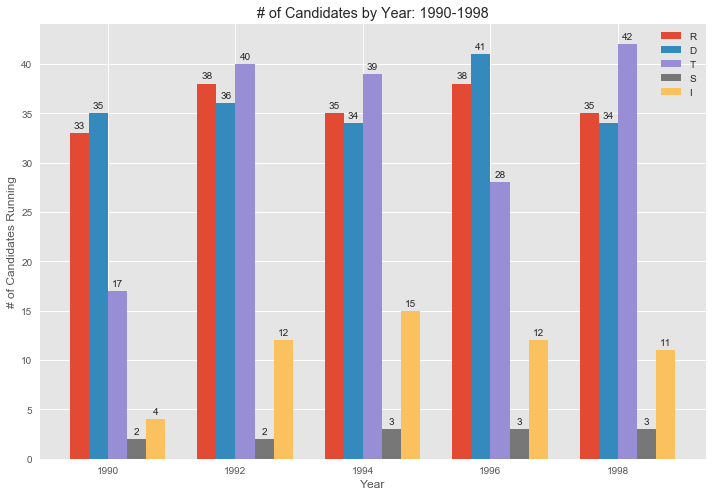

In [177]:
dlf.cand_per_yr_viewer(party_series_dict, '1990', '1998')

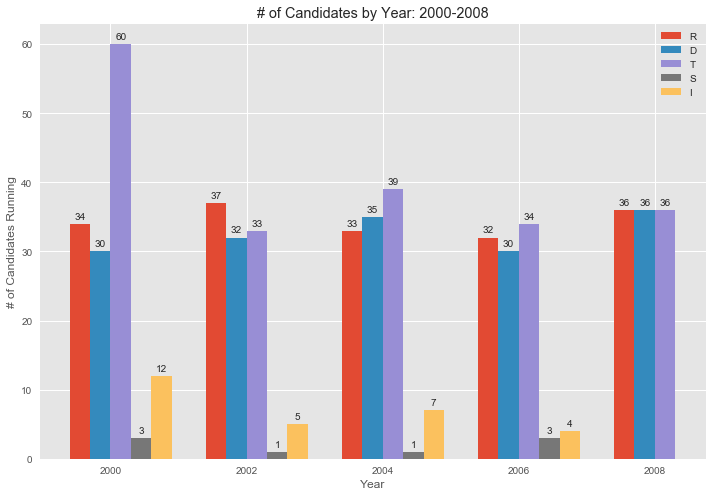

In [178]:
dlf.cand_per_yr_viewer(party_series_dict, '2000', '2008')

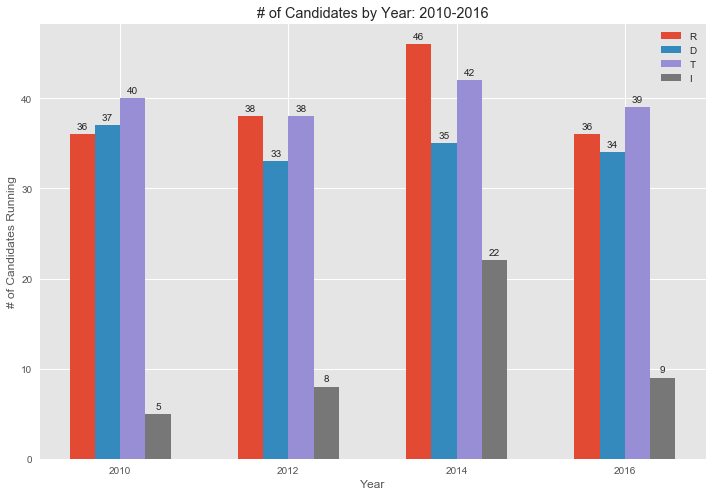

In [179]:
dlf.cand_per_yr_viewer(party_series_dict, '2010', '2016')

In [12]:
party_enc_list = ['D', 'R', 'I', 'S', 'T']
party_incumb_series_dict = {}

for party in party_enc_list:
    if party == 'D':
        dems_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = dems_by_year2
    elif party == 'R':
        repubs_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = repubs_by_year2
    elif party == 'I':
        indeps_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = indeps_by_year2
    elif party == 'S':
        socls_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = socls_by_year2
    elif party == 'T':
        thirds_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = thirds_by_year2

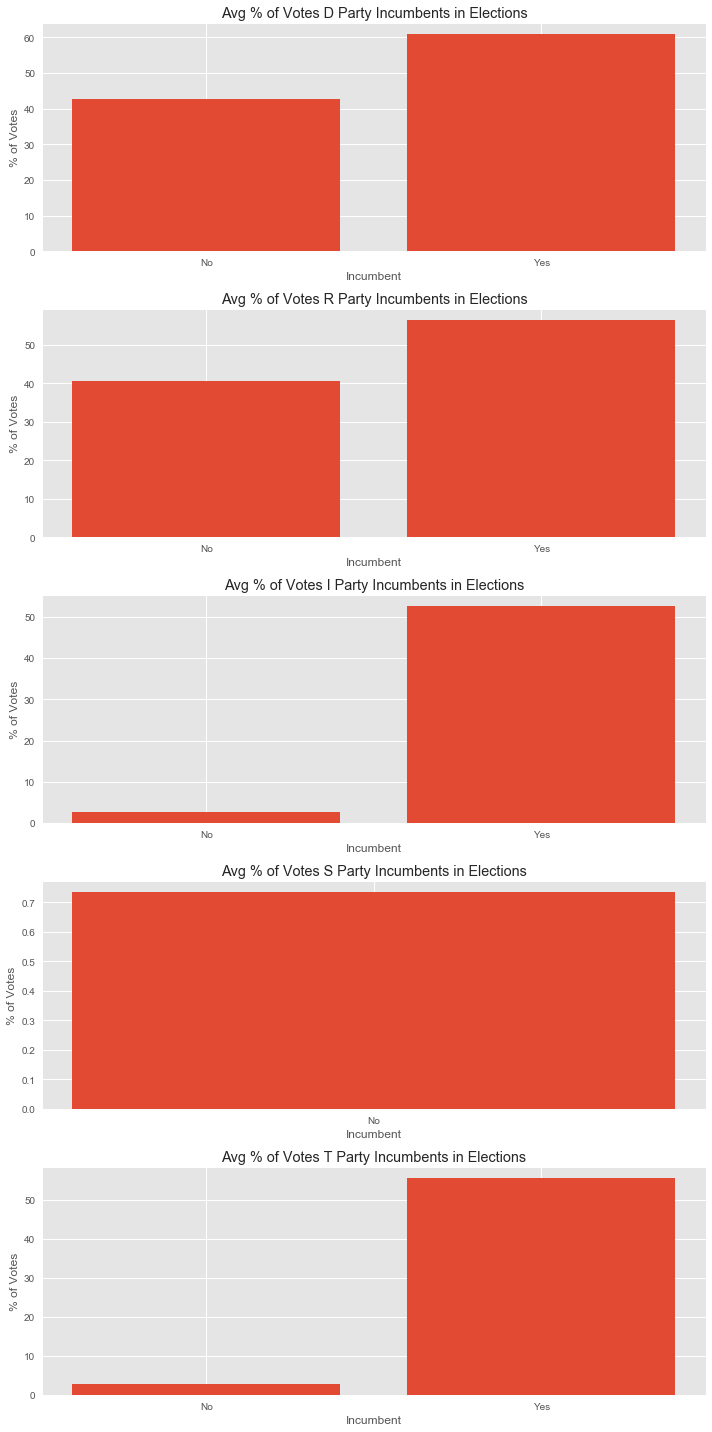

In [13]:
fig, ax = plt.subplots(figsize=(10,20), nrows=5)
axes = ax.flatten()

for i, party in enumerate(party_incumb_series_dict):
    series = party_incumb_series_dict[party].copy()
    
    try:
        series.set_axis(['No', 'Yes'], inplace=True)
        axes[i].bar(series.index, series)
        axes[i].set(title=f'Avg % of Votes {party} Party Incumbents in Elections', xlabel='Incumbent', ylabel='% of Votes')
        axes[i].set(xticks=['No', 'Yes'])
    except ValueError:
        series.set_axis(['No'], inplace=True)
        axes[i].bar(series.index, series)
        axes[i].set(title=f'Avg % of Votes {party} Party Incumbents in Elections', xlabel='Incumbent', ylabel='% of Votes')
        axes[i].set(xticks='No')
        

    plt.tight_layout();

## Prep for model

In [14]:
## Encoding year to help account for future values origin year = 2020
df_model_test['Year_enc'] = df_model_test['Year'].map(lambda x: x-2020)

## Drop name refs
df_model_test.drop(columns=['Cln_name', 'First_name', 'Year'], inplace=True)

## Fill NAs left from cleaning
df_model_test.dropna(inplace=True)

## Fixing State regex missed cases
df_model_test.at[1461, 'State'] = 'West_Virginia'
df_model_test.at[1632, 'State'] = 'Nevada'

## Setting variables + Q.C.
y = df_model_test.pop('%')
X = df_model_test.copy()
display(y.head())
display(X.head())
display(X.info())

## drop_first assumes that State = Alabama and Party = D
X_ohe = pd.get_dummies(X, drop_first=True)
display(X_ohe.columns)

## TT split
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, random_state=222)

0    66.10
1    33.05
2     0.85
3    69.27
4    29.51
Name: %, dtype: float64

,Turnout,Incumb_Y,State,Terms_in_office,Party_enc,Seats_up%,Seats_before%,Year_enc
0,233985.0,1,Alabama,1,D,0.361702,0.489583,-100
1,233985.0,0,Alabama,0,R,0.306122,0.510417,-100
2,233985.0,0,Alabama,0,S,0.000000,0.000000,-100
3,231960.0,0,Alabama,0,D,0.361702,0.489583,-100
4,231960.0,0,Alabama,0,R,0.306122,0.510417,-100


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5583 entries, 0 to 5587
Data columns (total 8 columns):
Turnout            5583 non-null float64
Incumb_Y           5583 non-null int64
State              5583 non-null object
Terms_in_office    5583 non-null int64
Party_enc          5583 non-null object
Seats_up%          5583 non-null float64
Seats_before%      5583 non-null float64
Year_enc           5583 non-null int64
dtypes: float64(3), int64(3), object(2)
memory usage: 392.6+ KB


None

Index(['Turnout', 'Incumb_Y', 'Terms_in_office', 'Seats_up%', 'Seats_before%',
       'Year_enc', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_Florida', 'State_Georgia', 'State_Hawaii',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'St

## Modelling

### Model Selection

#### Vanilla Models

In [15]:
## Instantiating a bunch of classifiers to test

tree_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor(n_jobs=-1)
knn_reg = KNeighborsRegressor(n_jobs=-1)
ada_reg = AdaBoostRegressor()
grad_reg = GradientBoostingRegressor()
xgb_reg = xgb.XGBRegressor(n_jobs=-1)

reg_list = [tree_reg, rf_reg, knn_reg, ada_reg, grad_reg, xgb_reg]

In [16]:
vanilla_metrics_df = dlf.regressor_tester(reg_list, X_train, X_test, y_train, y_test, display_res=True)

------------------------------ 6 regressors evaluated. ------------------------------


,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.tree._classes.DecisionTreeRegr...,10.350590,3.217233,0.984986,166.404906,12.899803,0.759106
1,<class 'sklearn.ensemble._forest.RandomForestR...,22.665933,4.760875,0.967122,117.400326,10.835143,0.830047
2,<class 'sklearn.neighbors._regression.KNeighbo...,491.824868,22.177125,0.286584,746.882478,27.329151,-0.081215
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,185.243853,13.610432,0.731295,206.410307,14.366987,0.701193
4,<class 'sklearn.ensemble._gb.GradientBoostingR...,99.063553,9.953068,0.856303,129.418961,11.376245,0.812648
5,<class 'xgboost.sklearn.XGBRegressor'>,101.361315,10.067836,0.852970,129.382346,11.374636,0.812701


#### GridSearchCV Prep

In [17]:
## Scoring functions
def rsqd_scorer(y_true, y_pred):
    from sklearn.metrics import r2_score
    
    score = r2_score(y_true, y_pred)
    
    return score

def rmse_scorer(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    import numpy as np
    
    score = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return score

def rmse_r2_scorer(y_true, y_pred):
    
    score = rmse_scorer(y_true, y_pred)
    rsqd_scorer(y_true, y_pred)
    
    return score

def two_scores(grtr_is_bttr=False):
    from sklearn.metrics import make_scorer
    
    return make_scorer(rmse_r2_scorer, greater_is_better=grtr_is_bttr)

## https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

#### Random Forest Regressor

In [19]:
## GridSearch for rf
params = {'n_jobs': [-1],
          'criterion': ['mse', 'mae'],
          'max_depth': [10],
          'n_estimators': [100, 200],
          'min_samples_leaf': [1, 2]}

test_grid = dlf.grid_searcher(rf_reg, params, X_train, X_test, y_train, y_test, cv=3, custom_scorer=dlf.two_scores())

display(test_grid.best_score_)
display(test_grid.best_estimator_.score(X_test, y_test))
test_grid.best_estimator_.score(X_train, y_train)

---- Timer started at: 08/27/2020 - 12:56 PM ----
---- Timer stopped at: 08/27/2020 - 01:00 PM ----
---- Time elasped: 0:04:05.628870 ----
Mean Training Score: -8.4
Mean Test Score: -1.1e+01
Best Parameters:
{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}


-10.610419420249615

0.8221583663116367

0.8931121273387673

In [ ]:
#-764.44/-1110.01
# params = {'n_jobs': [-1],
#           'criterion': ['mae', 'mse'],
#           'max_depth': [5, 10, 20, 40, 70, 100, None],
#           'n_estimators': [10, 50, 100],
#           'min_samples_leaf': [1, 2, 5]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-7.4/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [5, 10, 20, 40, 70, 100, None],
#           'n_estimators': [10, 50, 100],
#           'min_samples_leaf': [1, 2, 5]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-5.5/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [20, 30, 40, None],
#           'n_estimators': [80, 100, 120, 140],
#           'min_samples_leaf': [1, 2]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-6.5/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [10, 15, 20, None],
#           'n_estimators': [140, 160, 180, 200, 250, 300],
#           'min_samples_leaf': [1, 2]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-9.0/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [3, 5, 10, None],
#           'n_estimators': [200, 210, 220, 250],
#           'min_samples_leaf': [2]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

#### XGBoost Regressor

In [ ]:
# ## GridSearch for XGB
# params2 = {'n_jobs': [-1],
#           'learning_rate': [0.1],
#           'max_depth': [5, 7],
#           'n_estimators': [50],
#           'min_child_weight': [5]}

# test_grid2 = dlf.grid_searcher(xgb_reg, params2, X_train, X_test, y_train, y_test, cv=3, custom_scorer=two_scores())

# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# test_grid2.best_estimator_.score(X_train, y_train)

In [ ]:
# ## tr=68.96 te=81.84
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

In [ ]:
# ## tr=91.35 te=82.27
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

In [ ]:
# ## tr=89.33 te=81.92
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

In [ ]:
# ## tr=88.97 te=82.27
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

### Final Model

> Both `RandomForestRegressor()` and `XGBRegressor()` performed similarly during the vanilla run and testing/tuning. It turns out the the standard parameters work the best for now. I am choosing to go with the Random Forest for my final model, but either should be fine for future usage.

In [20]:
rf_reg_final = RandomForestRegressor(max_depth=20, n_estimators=200, min_samples_leaf=1, n_jobs=-1, random_state=24)
rf_fin_res_df, y_hat_train, y_hat_test = dlf.regressor_tester(rf_reg_final, X_train, X_test, y_train, y_test, display_res=True, keep_preds=True)

y_train_resids = y_hat_train - y_train
y_test_resids = y_hat_test - y_test

,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.ensemble._forest.RandomForestR...,30.774839,5.547507,0.95536,118.012349,10.863349,0.829161


### Results

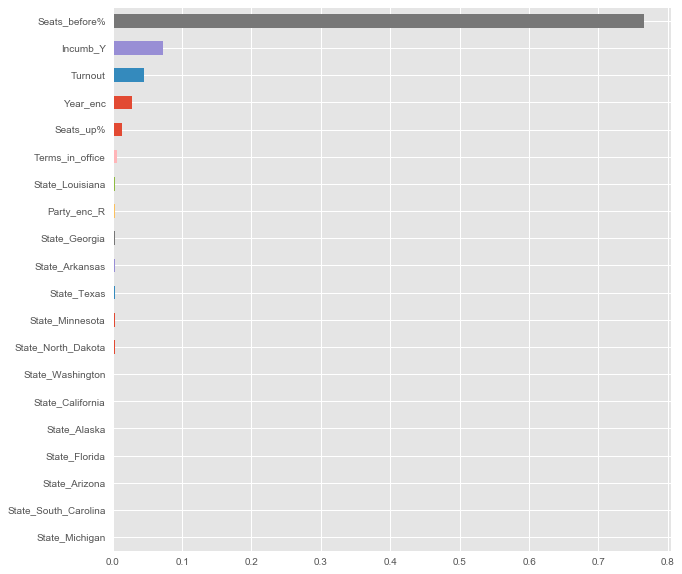

In [21]:
imps_ = dlf.plot_importance(rf_reg_final, X_train, top_n=20)

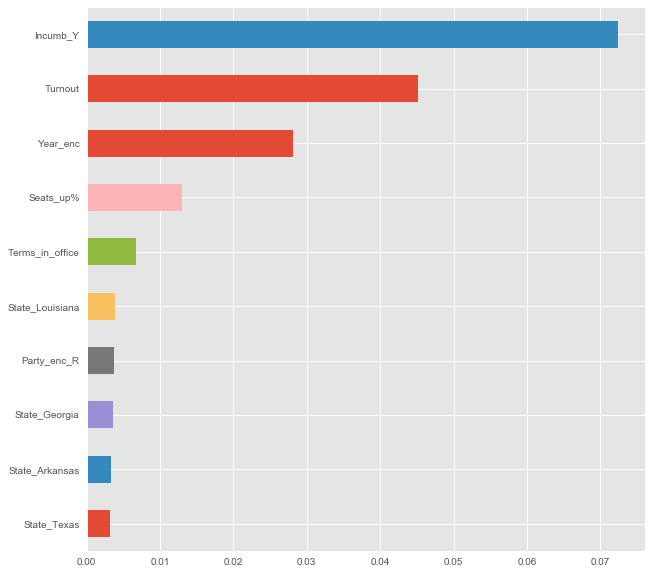

In [22]:
imps_.drop(index='Seats_before%').sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(10,10));

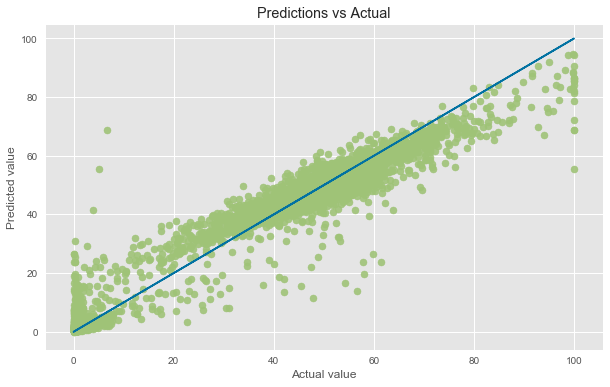

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(y_train, y_train, c='b')
ax.set(title='Predictions vs Actual', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_train, y_hat_train, c='g', alpha=0.9);

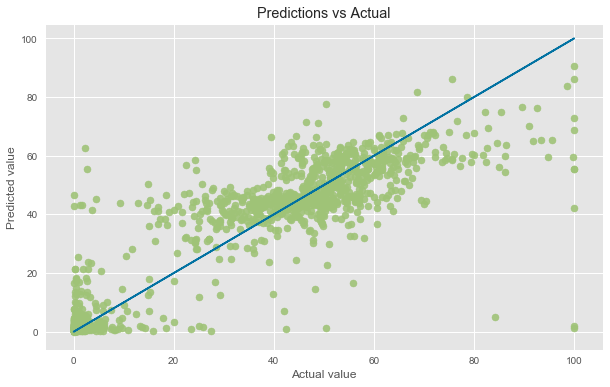

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(y_test, y_test, c='b')
ax.set(title='Predictions vs Actual', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_test, y_hat_test, c='g', alpha=0.9);

## Gender stuff

### Data Prep

#### Cleaning

In [62]:
## Function usage to add on genders 1000 at a time
# df_gend = gender_guesser(df_gend, online=True)

In [63]:
## Verison control + Q.C.
df_model_gend = df_gend.copy()
display(df_model_gend.info())
df_model_gend['Gender'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 12 columns):
%                  5588 non-null float64
Turnout            5583 non-null float64
Incumb_Y           5588 non-null int64
State              5588 non-null object
Cln_name           5588 non-null object
Year               5588 non-null int64
Terms_in_office    5588 non-null int64
Party_enc          5588 non-null object
First_name         5588 non-null object
Seats_up%          5588 non-null float64
Seats_before%      5588 non-null float64
Gender             5428 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 524.0+ KB


None

M    4921
F     507
Name: Gender, dtype: int64

In [64]:
## Helper list for male names misclassified
holder_m = ['James Eli Watson', 'Selden Spencer', 'Forsman', 'Trudell', 
          'Robert La Follette', 'Cherry', 'France', 'Eickelberg', 
          'Day', 'Kindler', 'Carey', 'Duly McCone', 'Huey Long', 'Lanier', 
          'Glen Corkery', 'Starr', 'Hager', 'Verhei', 'Happy Chandler', 
          'Philo Farnsworth', 'Ona Searles', 'Lewis Haley Tiley', 'Cecil Creel',
          'John Marion Morris', 'Lynn Frazier', 'Glen Taylor', 'Hanna',
          'Lynn Stumbaugh', 'Alexis DuPont Bayard', 'Arthur Vivian Watkins',
          'Val Bjornson', 'Laurence Pickett', 'Lou Welch', 'John Little McClellan',
          'Cecil Underwood', 'Melvin Babcock Morgan', 'Cecil Heftel', 'Cecil Pitard',
          'Laurence Burton', 'Lynn Henderson', 'Lorin Oxley', 'Chic Hecht',
          'Arlyn Wollenburg', 'Lou Gold', 'Mel Logan', 'Lindsey Graham',
          'Lamar Alexander', 'John Neely Kennedy', 'Maclyn Stringer', 'Cam Cavasso',
          'LeAlan Jones', 'Rand Paul', 'Tracy Potter', 'David Lory VanDerBeek',
          'Paul Lindsey Sadler']

## Helper list for non-specific names misclassified
holder_n = ['Miscellaneous', 'Others', 'Write-In Candidates']

## Helper list for items missed during initial cleaning
holder_c = ['Lawrence Gilfedder,Candidate for Governor in 1948. Ran for Governor in 1952 and 1954. Ran for Senate in 1958, 1960, 1962, 1964, 1966, and 1970.',
            'Jerry Zeldin, Laurel Springs', 'Howard Cannon, City Attorney of Las Vegas',
            'Douglas McKay,former Governor of Oregon  and United States Secretary of the Interior',
            'Efia Nwangaza*']

## Looping through each name in df, matching to helper lists, editing on the way
for i, name in zip(df_model_gend.index, df_model_gend['Cln_name']):
    ## Fixing male names
    for target in holder_m:
        if name == target:
            df_model_gend.at[i, 'Gender'] = 'M'
    ## Fixing non-specific names
    for target in holder_n:
        if name == target:
            df_model_gend.at[i, 'Gender'] = 'None'
    ## Fixing ea. case of cleaning respectively        
    if name == holder_c[0]:
        n_name = 'Lawrence Gilfedder'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[1]:
        n_name = 'Jerry Zeldin'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[2]:
        n_name = 'Howard Cannon'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[3]:
        n_name = 'Douglas Mckay'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[4]:
        n_name = 'Efia Nwangaza'
        df_model_gend.at[i, 'Cln_name'] = n_name
            
## Q.C.
display(df_model_gend.info())
df_model_gend['Gender'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 12 columns):
%                  5588 non-null float64
Turnout            5583 non-null float64
Incumb_Y           5588 non-null int64
State              5588 non-null object
Cln_name           5588 non-null object
Year               5588 non-null int64
Terms_in_office    5588 non-null int64
Party_enc          5588 non-null object
First_name         5588 non-null object
Seats_up%          5588 non-null float64
Seats_before%      5588 non-null float64
Gender             5428 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 524.0+ KB


None

M       5006
F        411
None      11
Name: Gender, dtype: int64

#### Train-Test Split

In [65]:
## Encoding year to help account for future values origin year = 2020
df_model_gend['Year_enc'] = df_model_gend['Year'].map(lambda x: x-2020)

## Drop name refs
df_model_gend.drop(columns=['Cln_name', 'First_name', 'Year'], inplace=True)

## Fill NAs left from cleaning
df_model_gend.dropna(inplace=True)

## Fixing State regex missed cases
df_model_gend.at[1461, 'State'] = 'West_Virginia'
df_model_gend.at[1632, 'State'] = 'Nevada'

## Setting variables + Q.C.
y_gend = df_model_gend.pop('%')
X_gend = df_model_gend.copy()
display(y_gend.head())
display(X_gend.head())
display(X_gend.info())

## drop_first assumes that State = Alabama and Party = D
X_ohe_gend = pd.get_dummies(X_gend, drop_first=True)
display(X_ohe_gend.columns)

## TT split
X_gend_train, X_gend_test, y_gend_train, y_gend_test = train_test_split(X_ohe_gend, y_gend, random_state=222)

0    66.10
1    33.05
2     0.85
3    69.27
4    29.51
Name: %, dtype: float64

,Turnout,Incumb_Y,State,Terms_in_office,Party_enc,Seats_up%,Seats_before%,Gender,Year_enc
0,233985.0,1,Alabama,1,D,0.361702,0.489583,M,-100
1,233985.0,0,Alabama,0,R,0.306122,0.510417,M,-100
2,233985.0,0,Alabama,0,S,0.000000,0.000000,M,-100
3,231960.0,0,Alabama,0,D,0.361702,0.489583,M,-100
4,231960.0,0,Alabama,0,R,0.306122,0.510417,M,-100


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5423 entries, 0 to 5587
Data columns (total 9 columns):
Turnout            5423 non-null float64
Incumb_Y           5423 non-null int64
State              5423 non-null object
Terms_in_office    5423 non-null int64
Party_enc          5423 non-null object
Seats_up%          5423 non-null float64
Seats_before%      5423 non-null float64
Gender             5423 non-null object
Year_enc           5423 non-null int64
dtypes: float64(3), int64(3), object(3)
memory usage: 423.7+ KB


None

Index(['Turnout', 'Incumb_Y', 'Terms_in_office', 'Seats_up%', 'Seats_before%',
       'Year_enc', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_Florida', 'State_Georgia', 'State_Hawaii',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'St

### Final Model

In [66]:
rf_reg_final = RandomForestRegressor(max_depth=20, n_estimators=200, min_samples_leaf=1, n_jobs=-1, random_state=24)
rf_fin_res_df, y_hat_train, y_hat_test = dlf.regressor_tester(rf_reg_final, X_train, X_test, y_train, y_test, display_res=True, keep_preds=True)

y_train_resids = y_hat_train - y_train
y_test_resids = y_hat_test - y_test

,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.ensemble._forest.RandomForestR...,30.774839,5.547507,0.95536,118.012349,10.863349,0.829161


In [67]:
rf_reg_final_gend = RandomForestRegressor(n_jobs=-1, random_state=90)
rf_fin_res_df_gend, y_hat_gend_train, y_hat_gend_test = dlf.regressor_tester(rf_reg_final_gend, X_gend_train, X_gend_test, y_gend_train, y_gend_test, display_res=True, keep_preds=True)

y_gend_train_resids = y_hat_gend_train - y_gend_train
y_gend_test_resids = y_hat_gend_test - y_gend_test

,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.ensemble._forest.RandomForestR...,23.415773,4.838985,0.966101,124.032353,11.136981,0.815284


### Results

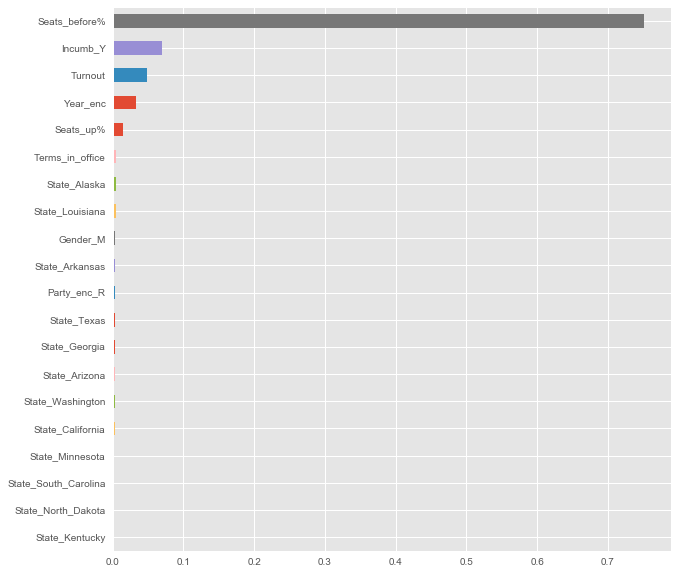

In [68]:
gend_imps = dlf.plot_importance(rf_reg_final_gend, X_gend_train, top_n=20)

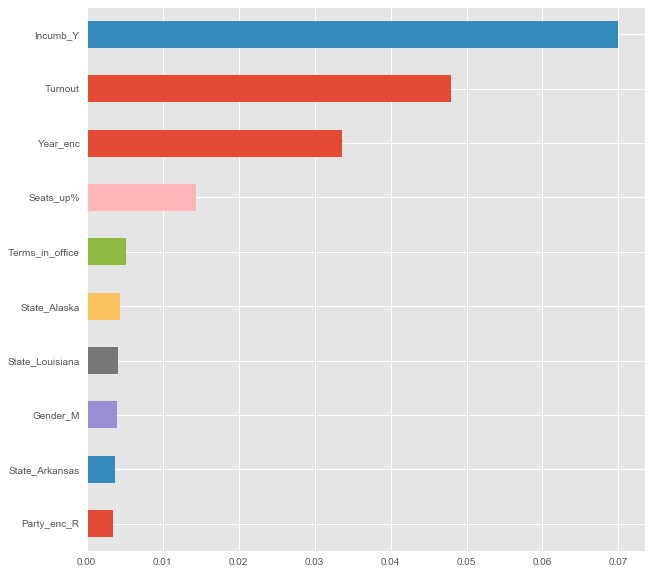

In [69]:
gend_imps.drop(index='Seats_before%').sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(10,10));

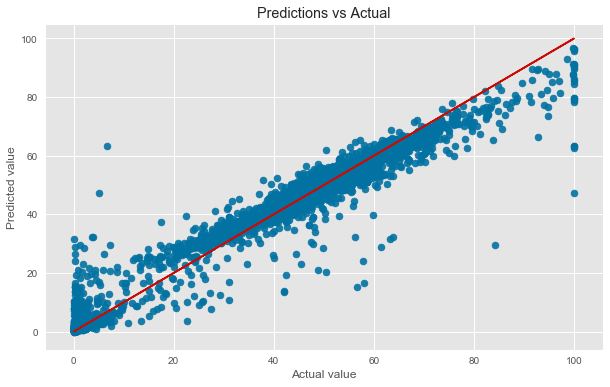

In [70]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(y_gend_train, y_gend_train, c='r')
ax.set(title='Predictions vs Actual', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_gend_train, y_hat_gend_train, c='b', alpha=0.9);

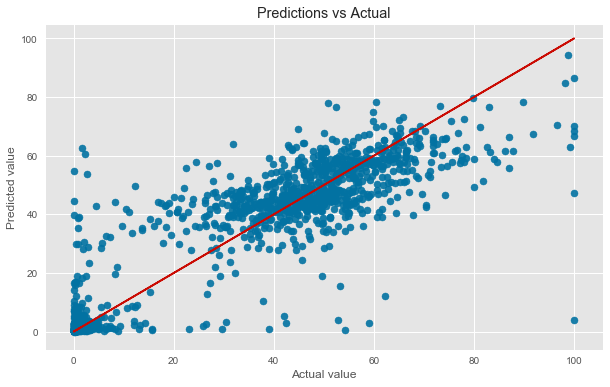

In [71]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(y_gend_test, y_gend_test, c='r')
ax.set(title='Predictions vs Actual', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_gend_test, y_hat_gend_test, c='b', alpha=0.9);

## Next..

In [72]:
## Make gender collection function #####################
## pickle/to_csv funct/df to Yish for help #############
## Keep year? Set_index as year (as datetime)
## Split % off as target ###############################
## OHE States, Party_enc ###############################
## RF/Tree Regressors 1st XGBoost? #####################
## add first_name columns into df_fin ##################
## Make sure Turnout is ok as int. #####################

In [73]:
# test_df = df[df['Year'] == 2006].copy()
# display(test_df.head())
# display(test_df.info())

In [74]:
# test_df = gender_guesser(test_df, count_max=50)
# display(test_df.head())
# display(test_df.tail())